In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import library
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from textblob import Word
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwords_scratch

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from keras.layers import Embedding

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#read csv
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/train_preprocess.tsv", sep='\t', names=['Text', 'Sentimen'])
data.head()

,Text,Sentimen
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


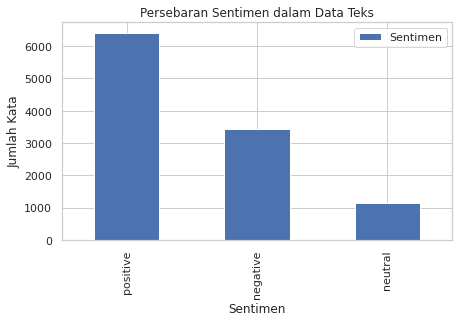

In [ ]:
data["Sentimen"].value_counts().plot.bar(figsize = (7, 4))
plt.title('Persebaran Sentimen dalam Data Teks')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()

In [ ]:
mapping = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}

data['label_val'] = data['Sentimen'].replace(mapping)
data['panjang_text'] = data['Text'].str.len()
data.head()

,Text,Sentimen,len,label_val,panjang_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,404,2,404
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,102,1,102
2,lokasi strategis di jalan sumatera bandung . t...,positive,184,2,184
3,betapa bahagia nya diri ini saat unboxing pake...,positive,93,2,93
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,214,0,214


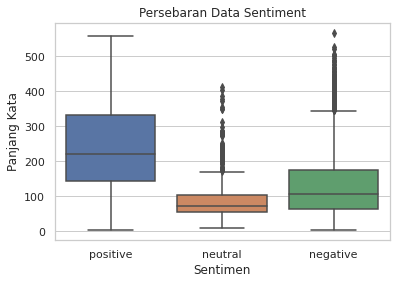

In [ ]:
#visualisasi dengan box plot

import seaborn as sns

sns.set_style('whitegrid')
sns.boxplot(y = data['panjang_text'] , x = data['Sentimen']);
plt.ylabel('Panjang Kata')
plt.title('Persebaran Data Sentiment')
plt.show()

In [ ]:
#persebaran data dengan standar deviation dan visualisasi
print(data['label_val'].describe(include=["all"]))

count    11000.000000
mean         1.270909
std          0.906818
min          0.000000
25%          0.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: label_val, dtype: float64


In [ ]:
print("Data Distribution")
print("mean: ",data['label_val'].mean())
print("variance: ",data['label_val'].var())
print("standar deviation: ",data['label_val'].std())

Data Distribution
mean:  1.270909090909091
variance:  0.8223193844068468
standar deviation:  0.9068182752938136


In [ ]:
#bagian kamus alay
data_alay = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Challenge Platinum/new_kamusalay.csv.xls', names=['alay','cleaned'], encoding ='latin-1')
data_alay

,alay,cleaned
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [ ]:
# Create Stopwords
list_stopwords = stopwords_scratch.words('indonesian')
list_stopwords_en = stopwords_scratch.words('english')
list_stopwords.extend(list_stopwords_en)
list_stopwords.extend(['ya','yg','ga','yuk','dah','baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'])

# External Stopwords
f = open("/content/drive/MyDrive/Colab Notebooks/Challenge Platinum/tala-stopwords-indonesia.txt", "r")
stopword_external = []
for line in f:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    stopword_external.append(line_list[0])
f.close()
list_stopwords.extend(stopword_external)

stopwords = list_stopwords

len(stopwords)

1710

In [ ]:
# Creating Function for Cleansing Process
def lowercase(text): # Change uppercase characters to lowercase
    return text.lower()

def special(text): # Remove all the special characters
    text = re.sub(r'\W', ' ',str(text), flags=re.MULTILINE)
    return text

def single(text): # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def singlestart(text): # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text, flags=re.MULTILINE)
    return text

def mulspace(text): # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    return text

def rt(text): # Remove RT
    text = re.sub(r'rt @\w+: ', ' ', text, flags=re.MULTILINE)
    return text

def prefixedb(text): # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text, flags=re.MULTILINE)
    return text

def misc(text): # Remove URL, Mention, Hashtag, user, Line, and Tab
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))|([#@]\S+)|user|\n|\t', ' ', text, flags=re.MULTILINE)
    return text

alay_mapping = dict(zip(data_alay['alay'], data_alay['cleaned'])) # Mapping for kamusalay
def alay(text): # Remove by replacing 'alay' words
    wordlist = text.split()
    text_alay = [alay_mapping.get(x,x) for x in wordlist]
    clean_alay = ' '.join(text_alay)
    return clean_alay

def stopwrds(text): # Stopwords fuction
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords]
    output_sw = ' '.join(tokens_without_sw)
    return output_sw

# Function for text cleansing
def cleaning(text):
    text = lowercase(text)
    text = special(text)
    text = single(text)
    text = singlestart(text)
    text = mulspace(text)
    text = rt(text)
    text = prefixedb(text)
    text = misc(text)
    text = alay(text)
    text = stopwrds(text)
    return text

In [ ]:
text = data['Text'].apply(lambda x: cleaning(x))
text

0        warung dimiliki pengusaha pabrik puluhan terke...
1        mohon ulama lurus k212 mmbri hujjah partai diw...
2        lokasi strategis jalan sumatra bandung nya nya...
3        betapa bahagia nya unboxing paket barang nya b...
4        aduh mahasiswa sombong kasih kartu kuning bela...
                               ...                        
10995                                               kecewa
10996    enak masakan nya kepiting menyenangkan memilih...
10997                     hormati partai partai berkoalisi
10998      pagi pagi tol pasteur macet parah bikin jengkel
10999    belanja yogyakarta riau junction lihat foodlif...
Name: Text, Length: 11000, dtype: object

In [ ]:
# Encoded the target column
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
data["Sentimen"] = lb.fit_transform(data["Sentimen"])
data["Sentimen"]

0        2
1        1
2        2
3        2
4        0
        ..
10995    2
10996    2
10997    1
10998    0
10999    2
Name: Sentimen, Length: 11000, dtype: int64

In [ ]:
#tokenizer
analisis = text.values
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(analisis)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(analisis)
x = pad_sequences(encoded_docs, maxlen=200)

In [ ]:
#Dump Tokenizer
import joblib

joblib.dump(tokenizer,'tokenizer.pkl')

['tokenizer.pkl']

In [ ]:
print(tokenizer.word_index)

{'nya': 1, 'enak': 2, 'makanan': 3, 'makan': 4, 'harga': 5, 'menu': 6, 'bandung': 7, 'banget': 8, 'restoran': 9, 'suasana': 10, 'malam': 11, 'nyaman': 12, 'jalan': 13, 'orang': 14, 'pelayanan': 15, 'ayam': 16, 'goreng': 17, 'suka': 18, 'bagus': 19, 'pemandangan': 20, 'nasi': 21, 'teman': 22, 'indonesia': 23, 'pilihan': 24, 'mahal': 25, 'sih': 26, 'lumayan': 27, 'kota': 28, 'cocok': 29, 'keluarga': 30, 'pas': 31, 'lokasi': 32, 'resto': 33, 'anak': 34, 'pesan': 35, 'porsi': 36, 'salah': 37, 'steak': 38, 'sunda': 39, 'minuman': 40, 'kafe': 41, 'khas': 42, 'rumah': 43, 'murah': 44, 'masakan': 45, 'mi': 46, 'ramah': 47, 'ramai': 48, 'bakso': 49, 'sambal': 50, 'oke': 51, 'favorit': 52, 'jam': 53, 'deh': 54, 'bakar': 55, 'menikmati': 56, 'mantap': 57, '2': 58, 'siang': 59, 'coba': 60, 'terjangkau': 61, 'partai': 62, 'mencoba': 63, 'daging': 64, '1': 65, 'bikin': 66, 'masuk': 67, 'luas': 68, 'cepat': 69, 'daerah': 70, 'memesan': 71, 'pedas': 72, 'jokowi': 73, 'pakai': 74, 'unik': 75, 'batagor'

In [ ]:
print(x[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  120 2206 3277 2918 1081  132  386    7  541 1513 1285
 1513  120  185    6  239 2044  141    6   16  217   23    5   61  696
    1 

In [ ]:
#evaluasi
embedding_vector_length = 32
model = Sequential() 
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           500448    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 60)                22320     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 3)                 183       
                                                                 
Total params: 522,951
Trainable params: 522,951
Non-trainable params: 0
__________________________________________________

In [ ]:
#training
from sklearn.model_selection import train_test_split

y=pd.get_dummies(data["Sentimen"])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [ ]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nAkurasi telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
batch_size = 32
history = model.fit(X_train, y_train, epochs = 50, batch_size = batch_size, validation_split=0.3, callbacks=[callbacks])

Epoch 1/50
169/169 [==============================] - 51s 272ms/step - loss: 0.4749 - accuracy: 0.6666 - val_loss: 0.3656 - val_accuracy: 0.7636
Epoch 2/50
169/169 [==============================] - 47s 279ms/step - loss: 0.3404 - accuracy: 0.7787 - val_loss: 0.2998 - val_accuracy: 0.7939
Epoch 3/50
169/169 [==============================] - 46s 272ms/step - loss: 0.2673 - accuracy: 0.8301 - val_loss: 0.2512 - val_accuracy: 0.8424
Epoch 4/50
169/169 [==============================] - 46s 271ms/step - loss: 0.1997 - accuracy: 0.8857 - val_loss: 0.2421 - val_accuracy: 0.8489
Epoch 5/50
169/169 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9065
Akurasi telah mencapai nilai > 90%!
169/169 [==============================] - 50s 293ms/step - loss: 0.1631 - accuracy: 0.9065 - val_loss: 0.2384 - val_accuracy: 0.8584


In [ ]:
model.evaluate(X_test,y_test)

104/104 [==============================] - 4s 34ms/step - loss: 0.2633 - accuracy: 0.8406


[0.26326984167099, 0.8406060338020325]

In [ ]:
#Save Model LSTM
model.save('model.h5')

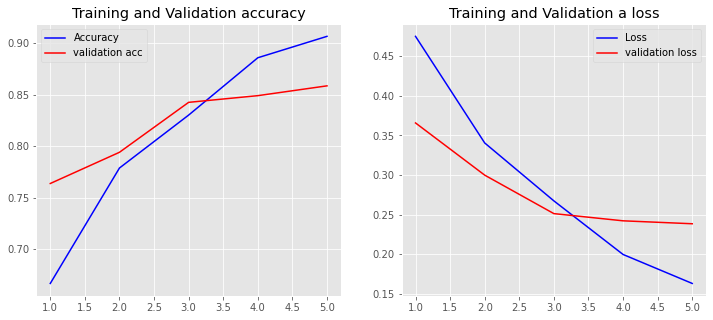

In [ ]:
#mengukur hasil prediksi dan hasil loss
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc)+1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Accuracy')
  plt.plot(x, val_acc, 'r', label='validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()
  
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Loss')
  plt.plot(x, val_loss, 'r', label='validation loss')
  plt.title('Training and Validation a loss')
  plt.legend()

%matplotlib inline
plot_history(history)

In [ ]:
def predict_sentiment(text):
    sentiment_tf = ['negative', 'neutral', 'positive']
    text = cleaning(text)
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw, maxlen=x.shape[1])
    prediction = model.predict(tw)
    polarity = np.argmax(prediction[0])
    return sentiment_tf[polarity]

In [ ]:
outputtf = predict_sentiment('hai semua')
print(outputtf)

1/1 [==============================] - 0s 317ms/step
neutral


In [ ]:
from sklearn import metrics

y_test = y_test.values
y_pred = model.predict(X_test)
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix_test)

104/104 [==============================] - 4s 34ms/step
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1031
           1       0.70      0.67      0.68       342
           2       0.89      0.91      0.90      1927

    accuracy                           0.84      3300
   macro avg       0.79      0.78      0.79      3300
weighted avg       0.84      0.84      0.84      3300



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=42, shuffle=True)

y = y.values

accuracies = []

for iteration, data in enumerate(kf.split(x), start=1):
  data_train = x[data[0]]
  target_train = y[data[0]]

  data_test = x[data[1]]
  target_test = y[data[1]]

  embedding_vector_length = 32
  model = Sequential() 
  model.add(Embedding(vocab_size, embedding_vector_length, input_length=200) )
  model.add(SpatialDropout1D(0.25))
  model.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dropout(0.2))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  

  batch_size = 32
  history = model.fit(X_train, y_train, epochs = 50, batch_size = batch_size, validation_split=0.3, callbacks=[callbacks])

  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  print('Training no: ', iteration)
  print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
  print('=================================================================')

  accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)

print()
print()
print()
print('Average Accuracy: ', average_accuracy)

Epoch 1/50
169/169 [==============================] - 50s 275ms/step - loss: 0.4808 - accuracy: 0.6583 - val_loss: 0.3525 - val_accuracy: 0.7736
Epoch 2/50
169/169 [==============================] - 52s 310ms/step - loss: 0.3451 - accuracy: 0.7727 - val_loss: 0.3113 - val_accuracy: 0.7892
Epoch 3/50
169/169 [==============================] - 46s 271ms/step - loss: 0.2820 - accuracy: 0.8171 - val_loss: 0.2581 - val_accuracy: 0.8247
Epoch 4/50
169/169 [==============================] - 49s 292ms/step - loss: 0.2077 - accuracy: 0.8761 - val_loss: 0.2379 - val_accuracy: 0.8502
Epoch 5/50
169/169 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9052
Akurasi telah mencapai nilai > 90%!
104/104 [==============================] - 6s 60ms/step
Training no:  1
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1031
           1       0.76      0.64      0.69       342
           2       0.91      0.89      0.90      1927